In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import sys
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import os
import csv
from helpers.outliers import MyOutliers
from skroutz_mobile import SkroutzMobile
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from skroutz_mobile import SkroutzMobile
from sklearn.model_selection import StratifiedShuffleSplit
from helpers.my_train_test_split import MySplitTrainTest
from sklearn.preprocessing import StandardScaler
from preprocess_price_history import PreprocessPriceHistory
from price_history import PriceHistory
from dfa import dfa
import scipy.signal as ss
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import silhouette_score
from os.path import isfile
from preprocess_price_history import PreprocessPriceHistory
from os.path import isfile
from sklearn.gaussian_process import GaussianProcessRegressor
from mobattrs_price_history_merger import MobAttrsPriceHistoryMerger
#from george import kernels
#import george
from sklearn.manifold import TSNE
import matplotlib  as mpl
import pickle
import dill

In [3]:
random_state = np.random.RandomState(seed=16011984)
%matplotlib inline

mpl.rc('figure', figsize=(17,7)) #setting the default value of figsize for our plots
#https://matplotlib.org/users/customizing.html

In [4]:
data_path = '../../../../Dropbox/data'
mobattrs_ph_path = data_path + '/mobattrs_price_history'
mobattrs_ph_norm_path = mobattrs_ph_path + '/mobattrs_ph_norm.npy'
sku_ids_groups_path = data_path + '/sku_ids_groups'
npz_sku_ids_group_kmeans_six = sku_ids_groups_path + '/sku_ids_kmeans_six.npz'

## Some processing

In [5]:
csv_in = "../price_history_03_seq_start_suddens_trimmed.csv"

In [6]:
#csv_out = "../price_history_for_sfa.csv"
#df_fixed_width.to_csv(csv_path, encoding='utf-8', quoting=csv.QUOTE_ALL)

In [7]:
ph = PriceHistory(csv_in)

In [8]:
seq = ph.extractSequenceByLocation(0)
print type(seq)
seq.shape, seq.name

<class 'pandas.core.series.Series'>


((210,), 10084353)

# Loading data

In [9]:
sku_id_groups = np.load(npz_sku_ids_group_kmeans_six)
for key, val in sku_id_groups.iteritems():
    print key, ",", val.shape

1 , (206,)
0 , (3,)
3 , (115,)
2 , (80,)
5 , (47,)
4 , (238,)


In [10]:
chosen_cluster = '3' #str because this is how values are stored as keys in npz files

In [11]:
mobiles_path = data_path + '/mobiles'

In [12]:
mobs_norm_path = mobiles_path + '/mobiles_norm.csv'
assert isfile(mobs_norm_path)

In [13]:
df = pd.read_csv(mobs_norm_path, index_col=0, encoding='utf-8', quoting=csv.QUOTE_ALL)
df.shape

(798, 139)

In [14]:
np.all(np.logical_not(np.isnan(df.values.flatten())))

True

In [15]:
cluster_sku_ids = set(sku_id_groups[chosen_cluster]).intersection(df.index)
len(cluster_sku_ids)

112

In [16]:
df_cluster = df.loc[cluster_sku_ids]
df_cluster.shape

(112, 139)

### merging

In [17]:
obj = MobAttrsPriceHistoryMerger(mobs_norm_path=mobs_norm_path, price_history_csv=csv_in)

In [20]:
%%time
dataframe = obj.get_table(df = df_cluster.drop(labels=SkroutzMobile.PRICE_COLS, axis=1), normalize_dates=True,
                         normalize_price=True)

CPU times: user 1.96 s, sys: 8 ms, total: 1.96 s
Wall time: 1.96 s


In [21]:
dataframe

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.166883,0.504262,-2.211499,1.840779,1.836493,-0.604376
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.280510,1.005089,-2.211499,1.850623,1.836493,-0.618117
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.394137,1.505916,-2.211499,1.860467,1.836493,-0.618117
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.507764,-1.499047,-2.211499,1.870310,1.836493,-0.618840
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.621391,-0.998220,-2.211499,1.880154,1.905860,-0.618840
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.735019,-0.497393,-2.211499,1.889998,1.905860,-0.618840
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.848646,0.003435,-2.211499,1.899842,1.905860,-0.618840
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,0.962273,0.504262,-2.211499,1.909686,1.905860,-0.626072
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,1.075900,1.005089,-2.211499,1.919530,1.905860,-0.618840
8742945,0.286418,0.586033,-0.17609,1.38675,0.360987,-0.266723,-0.705114,0.197642,0.310087,-0.187135,...,-0.433571,-0.356766,0.703808,1.830350,1.189527,1.505916,-2.211499,1.929374,1.905860,-0.618840


In [22]:
arr = dataframe.values

In [23]:
arr.shape

(17790, 144)

In [24]:
#mobattrs_ph_raw_path = mobattrs_ph_path + '/mobattrs_ph_raw.npy'
#np.save(mobattrs_ph_raw_path, arr)
#assert isfile(mobattrs_ph_raw_path)

In [25]:
np.all(np.logical_not(np.isnan(arr.flatten())))

True

In [26]:
# we are not saving
# np.save(mobattrs_ph_norm_path, arr_norm)
# assert isfile(mobattrs_ph_norm_path)

# Gaussian Process Regressor

In [28]:
XX = arr[:, :MobAttrsPriceHistoryMerger.PRICE_IND]
XX.shape

(17790, 143)

In [29]:
yy = arr[:, MobAttrsPriceHistoryMerger.PRICE_IND]
yy.shape

(17790,)

In [30]:
%%time
gp = GaussianProcessRegressor()
gp.fit(XX, yy)

CPU times: user 14min 22s, sys: 2min 2s, total: 16min 24s
Wall time: 3min 47s


# Reconstruct time series

we want to get the price values that correspond to a particular sku

but have we reserved this info ?? no..

In [36]:
# with open('cur_gp.pickle', 'w') as fp:  # Python 3: open(..., 'wb')
#     pickle.dump(gp, fp)

In [39]:
cur_sku_id = list(cluster_sku_ids)[0]
cur_sku_id

6317061

In [46]:
vals = dataframe.loc[cur_sku_id].values

In [48]:
xx = vals[:, :-1]
xx.shape

(212, 143)

In [49]:
tars = vals[:, -1]
tars.shape

(212,)

In [50]:
preds = gp.predict(xx)
preds.shape

(212,)

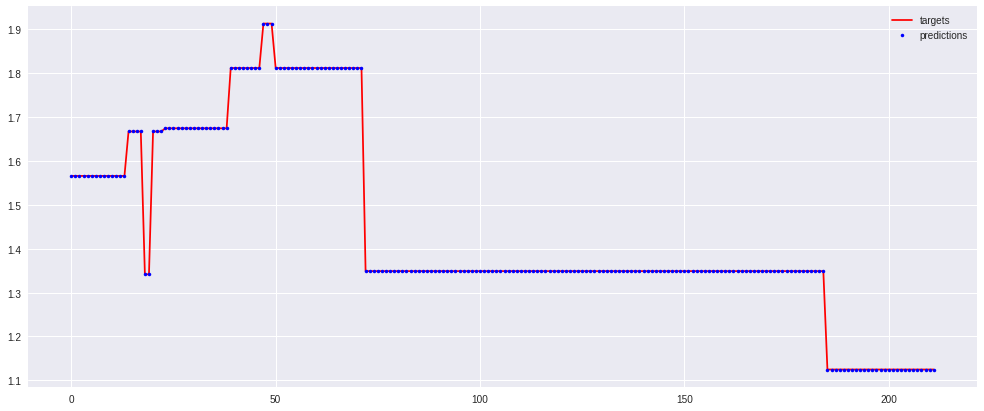

In [56]:
plt.figure()
plt.plot(tars, 'r-', label='targets')
plt.plot(preds, 'b.', label='predictions')
plt.legend()
plt.show()

# Train - Test

In [60]:
ph = PriceHistory(csv_in)

In [62]:
seqs = ph.extractAllSequences()

In [63]:
selseq = [seq for seq in seqs if seq.name == cur_sku_id]
assert len(selseq) == 1
selseq = selseq[0]

In [64]:
selseq.index

Index([u'2016-11-15', u'2016-11-16', u'2016-11-17', u'2016-11-18',
       u'2016-11-19', u'2016-11-20', u'2016-11-21', u'2016-11-22',
       u'2016-11-23', u'2016-11-24',
       ...
       u'2017-06-05', u'2017-06-06', u'2017-06-07', u'2017-06-08',
       u'2017-06-09', u'2017-06-10', u'2017-06-11', u'2017-06-12',
       u'2017-06-13', u'2017-06-14'],
      dtype='object', length=212)

In [66]:
target_len = 30

In [67]:
selseq.index[-target_len:]

Index([u'2017-05-16', u'2017-05-17', u'2017-05-18', u'2017-05-19',
       u'2017-05-20', u'2017-05-21', u'2017-05-22', u'2017-05-23',
       u'2017-05-24', u'2017-05-25', u'2017-05-26', u'2017-05-27',
       u'2017-05-28', u'2017-05-29', u'2017-05-30', u'2017-05-31',
       u'2017-06-01', u'2017-06-02', u'2017-06-03', u'2017-06-04',
       u'2017-06-05', u'2017-06-06', u'2017-06-07', u'2017-06-08',
       u'2017-06-09', u'2017-06-10', u'2017-06-11', u'2017-06-12',
       u'2017-06-13', u'2017-06-14'],
      dtype='object')

Continued in the next jupyter notebook